# Parse elapsed times from GitHub Actions logs

In [1]:
from utz import *
import plotly.express as px
from IPython.display import display, Markdown, Image

In [2]:
base_env_run_ids = [
    '4969272579',  # initial workflow, mamba CLI and conda-libmamba-solver only (5 jobs x 4 attempts)
    '4969923328',  # conda only (5 jobs x 4 attempts)
    '4970360885',  # additional runs of all 3 builds (conda, conda-libmamba-solver, mamba; 5 jobs x 4 attempts each)
    '4972844135',  # another round of both, switched to ubuntu:20.04 instead of nvidia/cuda:11.6.1-base-ubuntu20.04 (doesn t seem to make a difference)
    '4972941899',  # avoid nondeterministic `conda-libmamba-solver` installation failures (caused by including `-c conda-forge`) that were present in the above runs
    '4973140153',  # simplify the initial install/setup, don t bother pre-installing/pinning python or conda.
    '4973501857',  # same as above, but with [4 attempts] x [5 jobs] x [3 build types] (previous build inadvertently only ran 1 attempt per job)
]
new_env_run_ids = [
    '4973889484',  # install into a non-`base` env: `[conda|mamba] env update -n my-env`; `conda-libmamba-solver` becomes faster in this scenario
    '4974160990',  # install into a non-`base` env: `[conda|mamba] env update -n my-env`; `conda-libmamba-solver` becomes faster in this scenario
]

In [3]:
all_run_ids = base_env_run_ids + new_env_run_ids
md = f'''Parse and plot `env update` commands' elapsed times, from the following {len(all_run_ids)} GitHub Actions runs:\n'''
md += '\n'.join(
    f'- [Run {run_id}](https://github.com/runsascoded/libmamba-solver-test/actions/runs/{run_id})'
    for run_id in all_run_ids
)
md += "\n\nNote that the first 4 runs contained a few failures installing `conda-libmamba-solver`, due to `-c conda-forge` being used. That was removed in later runs, and in any case didn't seem to affect the elapsed time for `conda-libmamba-solver` runs that installed successfully. [More info here](https://github.com/runsascoded/libmamba-solver-test#conda-forge-failures)."
display(Markdown(md))

Parse and plot `env update` commands' elapsed times, from the following 9 GitHub Actions runs:
- [Run 4969272579](https://github.com/runsascoded/libmamba-solver-test/actions/runs/4969272579)
- [Run 4969923328](https://github.com/runsascoded/libmamba-solver-test/actions/runs/4969923328)
- [Run 4970360885](https://github.com/runsascoded/libmamba-solver-test/actions/runs/4970360885)
- [Run 4972844135](https://github.com/runsascoded/libmamba-solver-test/actions/runs/4972844135)
- [Run 4972941899](https://github.com/runsascoded/libmamba-solver-test/actions/runs/4972941899)
- [Run 4973140153](https://github.com/runsascoded/libmamba-solver-test/actions/runs/4973140153)
- [Run 4973501857](https://github.com/runsascoded/libmamba-solver-test/actions/runs/4973501857)
- [Run 4973889484](https://github.com/runsascoded/libmamba-solver-test/actions/runs/4973889484)
- [Run 4974160990](https://github.com/runsascoded/libmamba-solver-test/actions/runs/4974160990)

Note that the first 4 runs contained a few failures installing `conda-libmamba-solver`, due to `-c conda-forge` being used. That was removed in later runs, and in any case didn't seem to affect the elapsed time for `conda-libmamba-solver` runs that installed successfully. [More info here](https://github.com/runsascoded/libmamba-solver-test#conda-forge-failures).

### Local cache for logs and run info downloaded via the `gh` CLI

In [4]:
CACHE = '.cache'
if not exists(CACHE):
    os.makedirs(CACHE)

### Parse `elapsed` time (output by `time docker build …`) for all steps in a given job

In [5]:
# Plain `conda` builds had an initial setup install prior to this GHA run (which output an "elapsed" time that gets picked up by `get_elapsed_times` below)
min_conda_no_setup_run = '4973140153'

def rm_ansi(line):
    ansi_escape =re.compile(r'(\x9B|\x1B\[)[0-?]*[ -\/]*[@-~]')
    return ansi_escape.sub('', line)

def get_elapsed_times(run_id, job_id, build):
    path = f'{CACHE}/job-{job_id}.txt'
    if not exists(path):
        cmd = [ 'gh', 'run', 'view', '--job', f'{job_id}', '--log' ]
        with open(path, 'w') as f:
            subprocess.run(cmd, stdout=f)

    setup = None
    updates = []
    with open(path, 'r') as f:
        for line in f.readlines():
            m = search(r'(?P<elapsed>\S+)elapsed', rm_ansi(line))
            if m:
                elapsed = m['elapsed']
                if setup or (run_id > min_conda_no_setup_run and build == 'conda'):
                    updates.append(elapsed)
                else:
                    setup = elapsed
    rv = dict(updates=updates)
    if setup:
        rv['setup'] = setup
    return rv

### Parse elapsed times for all jobs in a given workflow run

In [6]:
def mark_attempt_failed(df):
    max_attempt = df.attempt.max()
    df = df.copy()
    df['label'] = df['build']
    if (df.conclusion == 'failure').any():
        max_attempt_mask = df.attempt == max_attempt
        df.loc[max_attempt_mask, 'label'] = df.loc[max_attempt_mask, 'build'].apply(lambda l: f'{l} (failed)')
    return df

def get_jobs_json(run_id, recompute=False):
    jobs_path = f'{CACHE}/run-{run_id}-jobs.json'
    if recompute or not exists(jobs_path):
        with open(jobs_path, 'w') as f:
            cmd = [ 'gh', 'run', 'view', run_id, '--json', 'jobs' ]
            err(f'Piping `{shlex.join(cmd)}` to {jobs_path}')
            subprocess.run(cmd, stdout=f)
    with open(jobs_path, 'r') as f:
        jobs_json = json.load(f)

    return jobs_json

def get_run_times(run_id, recompute=False):
    run_times_path = f'{CACHE}/run-{run_id}-times.parquet'
    if (
        recompute is True or
        recompute == 'times' or
        (isinstance(recompute, list) and run_id in recompute) or
        not exists(run_times_path)
    ):
        recompute_jobs = (
            recompute == 'jobs' or
            recompute is True or
            (isinstance(recompute, list) and 'jobs' in recompute)
        )
        jobs_json = get_jobs_json(run_id, recompute=recompute_jobs)
        jobs = (
            DF(jobs_json)
            .jobs
            .apply(Series)
            .rename(columns={ 'databaseId': 'job_id' })
            .set_index('job_id')
        )
        jobs = sxs(
            jobs,
            jobs.name.str.extract(r'(?P<build>mamba-(?:cli|solver)|conda-libmamba-solver|conda|mamba).*(?P<job>\d+)'),
            jobs.url.str.extract(r'^.*/(?P<url_id>\d+)$').url_id,
        )
        jobs['run_id'] = run_id

        job_times = sxs(
            DF([
                dict(
                    job_id=job_id,
                    **get_elapsed_times(
                        run_id=run_id,
                        job_id=job_id,
                        build=jobs.loc[job_id, 'build'],
                    )
                )
                for job_id in jobs.index
            ])
            .set_index('job_id'),
            jobs[['url_id', 'run_id', 'conclusion', 'build', 'job']],
        )

        setups = job_times.setup.rename('elapsed_str').to_frame()
        setups['attempt'] = -1  # initial setup: install `conda-libmamba-solver`, `mamba`, or nothing (in the case of plain `conda` build)

        step_times = job_times.updates.apply(Series)
        step_times = (
            step_times
            .reset_index()
            .melt(
                'job_id',
                step_times.columns.tolist(),
                var_name='attempt',
                value_name='elapsed_str',
            )
            .dropna()
        )
        step_times = (
            pd.concat([ step_times, setups.reset_index() ])
            .set_index('job_id')
            .dropna()
        )

        merged = step_times.merge(jobs[['build', 'run_id', 'conclusion']], on='job_id')
        p = merged.elapsed_str.str.extract(r'^(?P<m>\d+):(?P<s>\d+)\.(?P<cs>\d+)$').applymap(int)
        elapsed_s = p.m * 60 + p.s + p.cs / 100
        merged['elapsed_s'] = elapsed_s
        merged['elapsed_m'] = elapsed_s / 60
        merged = merged.drop(columns='elapsed_str')

        merged.loc[merged.build == 'mamba-solver', 'build'] = 'conda-libmamba-solver'
        merged.loc[merged.build == 'mamba-cli', 'build'] = 'mamba'
        merged['label'] = merged['build']

        merged = merged.groupby(['run_id', 'job_id'], as_index=False).apply(mark_attempt_failed)        
        
        merged = (
            merged
            .reset_index()
            .set_index(['run_id', 'job_id', 'attempt'])
            .sort_index()
        )
        merged.to_parquet(run_times_path)
    return read_parquet(run_times_path)

### Combine elapsed times for all workflow runs listed in `runs` above

In [7]:
def get_attempts(run_ids, recompute=None, include_failures=False):
    all_attempts = (
        pd.concat([
            get_run_times(run_id, recompute=recompute)
            for run_id in run_ids
        ])
        .reset_index()
        .sort_values(['build', 'run_id', 'attempt'])
    )

    # Verify `job_id`:`build` is 1:1
    assert (
        all_attempts
        [['job_id', 'build']]
        .value_counts()
        .reset_index()
        .job_id
        .value_counts()
        .value_counts()
        .index
        .tolist()
    ) == [1]

    setups_mask = all_attempts.attempt == -1
    setups = all_attempts[setups_mask]
    updates = all_attempts[~setups_mask]
    successes = updates[updates.conclusion == 'success']

    means = successes.groupby('build').elapsed_m.mean().to_dict()
    libmamba_mean = means['conda-libmamba-solver']
    mamba_mean = means['mamba']
    if libmamba_mean < mamba_mean:
        speedup = 1 - libmamba_mean / mamba_mean
        speedup_pct = int(100 * speedup)
        print(f'conda-libmamba-solver is {speedup_pct}% faster than mamba')
    else:
        speedup = 1 - mamba_mean / libmamba_mean
        speedup_pct = int(100 * speedup)
        print(f'mamba is {speedup_pct}% faster than conda-libmamba-solver')

    return updates if include_failures else successes

### Plot elapsed time for each build type

In [8]:
colors = px.colors.qualitative.Plotly
color_discrete_map = {
    'conda': colors[0],
    'conda (failed)': colors[1],
    'conda-libmamba-solver (failed)': colors[1],
    'conda-libmamba-solver': colors[2],
    'mamba': colors[3],
}

In [9]:
base_envs = get_attempts(base_env_run_ids)
base_envs

mamba is 81% faster than conda-libmamba-solver


,run_id,job_id,attempt,level_0,build,conclusion,elapsed_s,elapsed_m,label
45,4969923328,13460568257,0,0,conda,success,678.20,11.303333,conda
50,4969923328,13460568304,0,1,conda,success,890.64,14.844000,conda
55,4969923328,13460568371,0,2,conda,success,622.85,10.380833,conda
60,4969923328,13460568428,0,3,conda,success,761.96,12.699333,conda
65,4969923328,13460568477,0,4,conda,success,608.12,10.135333,conda
...,...,...,...,...,...,...,...,...,...
294,4973501857,13467438127,3,10,mamba,success,129.31,2.155167,mamba
299,4973501857,13467438200,3,11,mamba,success,130.36,2.172667,mamba
304,4973501857,13467438270,3,12,mamba,success,134.20,2.236667,mamba
309,4973501857,13467438324,3,13,mamba,success,145.63,2.427167,mamba


In [10]:
def plot_attempts(attempts, name, env, color='label', showlegend=False, dtick=2, layout=None, **kwargs):
    max_duration = attempts.elapsed_m.max()
    builds = ['conda', 'conda-libmamba-solver', 'mamba']
    #build_order = { build: idx for idx, build in enumerate(builds)}
    fig = px.strip(
        attempts,
        x='build',
        y='elapsed_m',
        color=color,
        labels={ 'build': '', 'label': '', 'elapsed_m': 'Elapsed (mins)', },
        color_discrete_map=color_discrete_map,
        category_orders={'build': builds},
        **kwargs,
    ).update_layout(
        title=dict(
            text=f'`[conda|mamba] env update -n {env}` run-time',
            x=0.5,
        ),
        yaxis=dict(
            tickformat='%M',
        ),
        **(layout or {}),
        showlegend=showlegend,
    ).update_yaxes(
        range=[-0.02 * max_duration, max_duration * 1.05],
        tickmode='linear',
        tick0=0,
        dtick=dtick,
        #rangemode='tozero',
    )
    for build in builds:
        for label in [ build, f'{build} (failed)' ]:
            fig.update_traces(
                selector=dict(name=label),
                offsetgroup=0
            )
    
    png_path = f'{name}.png'
    fig.write_image(png_path, width=900, height=600)
    display(Image(filename=png_path))
    #fig.show()

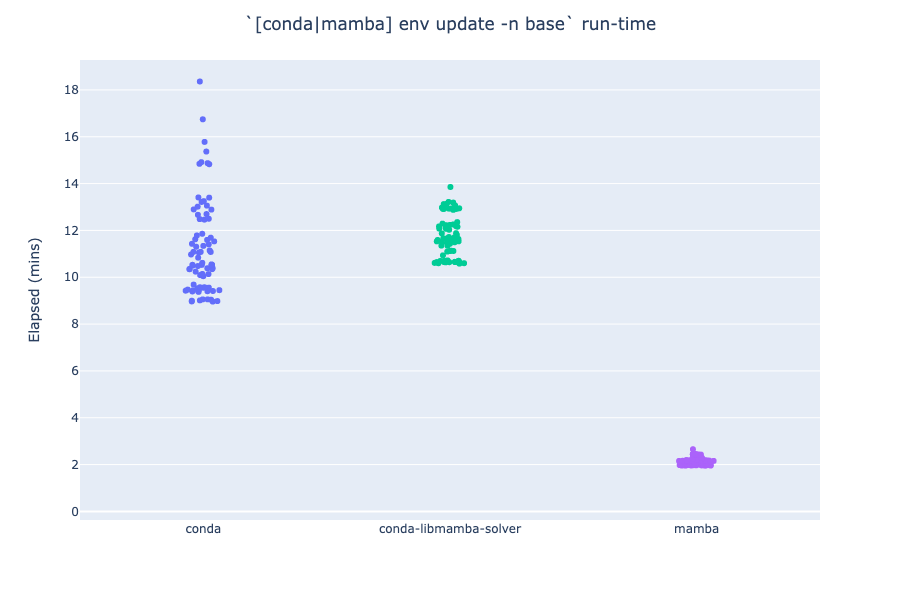

In [11]:
plot_attempts(base_envs, name='run-times-base-env', env='base')

In [12]:
new_envs = get_attempts(new_env_run_ids, include_failures=True)
new_envs

conda-libmamba-solver is 32% faster than mamba


,run_id,job_id,attempt,level_0,build,conclusion,elapsed_s,elapsed_m,label
0,4973889484,13468147903,0,0,conda,failure,1017.11,16.951833,conda
2,4973889484,13468147959,0,1,conda,failure,363.57,6.059500,conda (failed)
3,4973889484,13468148014,0,2,conda,success,741.09,12.351500,conda
6,4973889484,13468148068,0,3,conda,failure,784.77,13.079500,conda
1,4973889484,13468147903,1,0,conda,failure,505.97,8.432833,conda (failed)
4,4973889484,13468148014,1,2,conda,success,746.21,12.436833,conda
7,4973889484,13468148068,1,3,conda,failure,350.29,5.838167,conda (failed)
5,4973889484,13468148014,2,2,conda,success,737.66,12.294333,conda
9,4973889484,13468148103,0,4,conda-libmamba-solver,success,107.18,1.786333,conda-libmamba-solver
13,4973889484,13468148157,0,5,conda-libmamba-solver,success,117.57,1.959500,conda-libmamba-solver


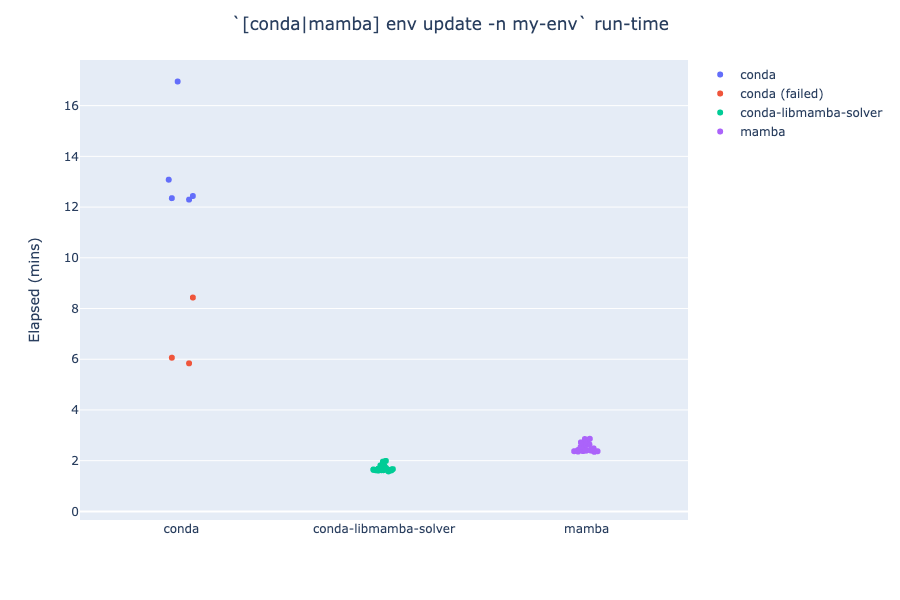

In [13]:
plot_attempts(
    new_envs,
    name='run-times-new-env',
    env='my-env',
    showlegend=True,
)